In [1]:
import torch
import numpy as np
import cv2
import time
import datetime
import pandas as pd
from PIL import Image
from yolov5.models.experimental import attempt_load
import warnings
warnings.filterwarnings(action = 'ignore')

from convert_data import collect_data, collect_coordinates
from class_mapping import yolo_class_mapping, fire_class_mapping, animals_class_mapping, obstacle_class_mapping
from detection import category
from perform_object import perform_object
from yolo_to_server import send_server
from create_polygon import check_polylist

WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")



### Version check

In [2]:
print('opencv version: ', cv2.__version__)

opencv version:  4.8.0


### Set Trained Models & Camera setting

In [3]:
camera_name = 'KFQ StarValley'
device = torch.device('cpu')

# Load trained YOLOv5 model weights
yolo_weights_path = '/Users/bongeungu/Desktop/kfq/KFQ_TEAM01/yolo/models/yolov5m.pt'
fire_weights_path = '/Users/bongeungu/Desktop/kfq/KFQ_TEAM01/yolo/models/fire_smoke.pt'
animals_weights_path = '/Users/bongeungu/Desktop/kfq/KFQ_TEAM01/yolo/models/animals.pt'
obstacle_weights_path = '/Users/bongeungu/Desktop/kfq/KFQ_TEAM01/yolo/models/obstacle.pt'

yolo_model = attempt_load(yolo_weights_path, device=device)
fire_model = attempt_load(fire_weights_path, device=device)
animals_model = attempt_load(animals_weights_path, device=device)
obstacle_model = attempt_load(obstacle_weights_path, device=device)

Fusing layers... 
YOLOv5m summary: 369 layers, 21190557 parameters, 0 gradients
Fusing layers... 
YOLOv5m summary: 369 layers, 20879400 parameters, 0 gradients, 48.2 GFLOPs
Fusing layers... 
YOLOv5m summary: 369 layers, 20887482 parameters, 0 gradients, 48.3 GFLOPs
Fusing layers... 
YOLOv5m summary: 369 layers, 20887482 parameters, 0 gradients, 48.3 GFLOPs


### Save coordinates for road boundary detection

      X1   Y1    X2   Y2 Class_Name
0   1720  378  1918  638        bus
1   1625  367  1918  660        bus
2   1524  354  1918  674        bus
3   1423  355  1917  703        bus
4   1319  359  1915  712        bus
5   1210  362  1917  721        bus
6   1088  364  1913  725        bus
7    971  368  1910  728        bus
8    863  370  1834  727        bus
9    751  371  1714  729        bus
10   623  371  1589  730        bus
11   499  374  1465  730        bus
12   364  373  1336  733        bus
13   221  374  1212  733        bus
14   101  373  1081  736        bus
15     3  372   958  737        bus
16     2  374   830  737        bus
17     3  370   684  735        bus
18     1  370   579  737        bus
19     0  377   479  738        bus
20     1  386   325  723        bus
21  1763  454  1919  624        car
22  1688  464  1918  643        car
23  1610  469  1880  661        car
24  1533  473  1844  678        car
25  1451  470  1780  696        car
26  1272  483  1819  712    

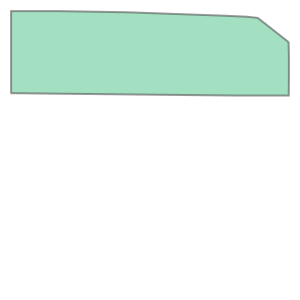

In [6]:
# Initialize webcam
cap = cv2.VideoCapture(0)

columns = ['X1', 'Y1', 'X2', 'Y2', 'Class_Name']
road_coordinates = pd.DataFrame(columns=columns)
sidewalk_coordinates = pd.DataFrame(columns=columns)

for i in range(200):
    ret, frame = cap.read()
    
    image = Image.fromarray(frame)
    image = image.resize((640,640))
    image_tensor = torch.from_numpy(np.array(image)).float().permute(2, 0, 1) / 255.0
    image_tensor = image_tensor.unsqueeze(0).to(device)
    
    results = perform_object(image_tensor, 0.65, yolo_model)
    road_coordinates, sidewalk_coordinates = collect_coordinates(results, frame, yolo_class_mapping, road_coordinates, sidewalk_coordinates)

cap.release()
print(road_coordinates)
print(f'coodrinates count: {len(road_coordinates)}')

# Create road boundary polygon using road coordinates data
polygon = check_polylist(road_coordinates)
polygon

### Object Detection using webcam

In [8]:
# Initialize webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()  # Read frame from the webcam
    captured_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S") # 상황 발생 시간 기록
    print(captured_time)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to exit the loop
        break
    
    # reset dataframe
    columns = ['Time', 'Class_Name', 'Confidence', 'X1', 'Y1', 'X2', 'Y2', 'action_detection', 'action_category', 'event_type']
    results_df = pd.DataFrame(columns=columns)
    
    # Preprocess the frame
    image = Image.fromarray(frame)
    image = image.resize((640, 640))  # Resize the image to the model's input size
    image_tensor = torch.from_numpy(np.array(image)).float().permute(2, 0, 1) / 255.0
    image_tensor = image_tensor.unsqueeze(0).to(device)

    # Perform object detection
    results = perform_object(image_tensor, 0.65, yolo_model)
    results_df = collect_data(results, frame, yolo_class_mapping, results_df, captured_time)
    #print(results_df)
    
    results = perform_object(image_tensor, 0.3, fire_model)
    results_df = collect_data(results, frame, fire_class_mapping, results_df, captured_time)
    
    results = perform_object(image_tensor, 0.65, animals_model)
    results_df = collect_data(results, frame, animals_class_mapping, results_df, captured_time)
    
    results = perform_object(image_tensor, 0.4, obstacle_model)
    results_df = collect_data(results, frame, obstacle_class_mapping, results_df, captured_time)
    
    results_df = category(results_df, polygon)
    print(results_df)

    # Display the frame with bounding boxes and labels
    cv2.imshow(camera_name, frame)
    
    #send_server(results_df, camera_name, frame)
    
    time.sleep(2) # 2초 간격으로 사진 캡쳐

# Release the webcam and close windows
cap.release()
cv2.destroyAllWindows()

2023-08-28 14:12:23
state: 1
                  Time Class_Name       Confidence    X1   Y1    X2    Y2  \
0  2023-08-28 14:12:23       fire  tensor(0.60540)  1647  654  1920  1007   

   action_detection action_category event_type  
0                 1   fire detected        F01  
2023-08-28 14:12:26
state: 1
                  Time Class_Name       Confidence    X1   Y1    X2    Y2  \
0  2023-08-28 14:12:26       fire  tensor(0.58386)  1647  654  1920  1010   

   action_detection action_category event_type  
0                 1   fire detected        F01  
2023-08-28 14:12:29
state: 1
state: 1
state: 1
                  Time Class_Name       Confidence    X1   Y1    X2   Y2  \
0  2023-08-28 14:12:29        car  tensor(0.93349)   718  559  1226  749   
1  2023-08-28 14:12:29        car  tensor(0.87868)  1705  497  1919  645   
2  2023-08-28 14:12:29       fire  tensor(0.61850)  1671  670  1915  936   

   action_detection action_category event_type  
0                 0             NaN

KeyboardInterrupt: 